# 均匀势场中的相对论粒子
$ L = (1-\dot{q}^2)^{-\frac{1}{2}}-1 + gq $   
$ \ddot{q} = \frac{g (1-\dot{q}^2)^{2.5}}{1+2\dot{q}^2}$

<>:37: SyntaxWarning: invalid escape sequence '\d'
<>:39: SyntaxWarning: invalid escape sequence '\d'
<>:37: SyntaxWarning: invalid escape sequence '\d'
<>:39: SyntaxWarning: invalid escape sequence '\d'
C:\Users\19464\AppData\Local\Temp\ipykernel_20348\1855900278.py:37: SyntaxWarning: invalid escape sequence '\d'
  plt.plot(sol.t, qdot, label='$\dot{q}(t)$', color='r')
C:\Users\19464\AppData\Local\Temp\ipykernel_20348\1855900278.py:39: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel('Velocity $\dot{q}$')
C:\Users\19464\AppData\Local\Temp\ipykernel_20348\1855900278.py:8: RuntimeWarning: invalid value encountered in scalar power
  qddot = g * (1 - qdot**2)**(5/2) / (1 + 2 * qdot**2)


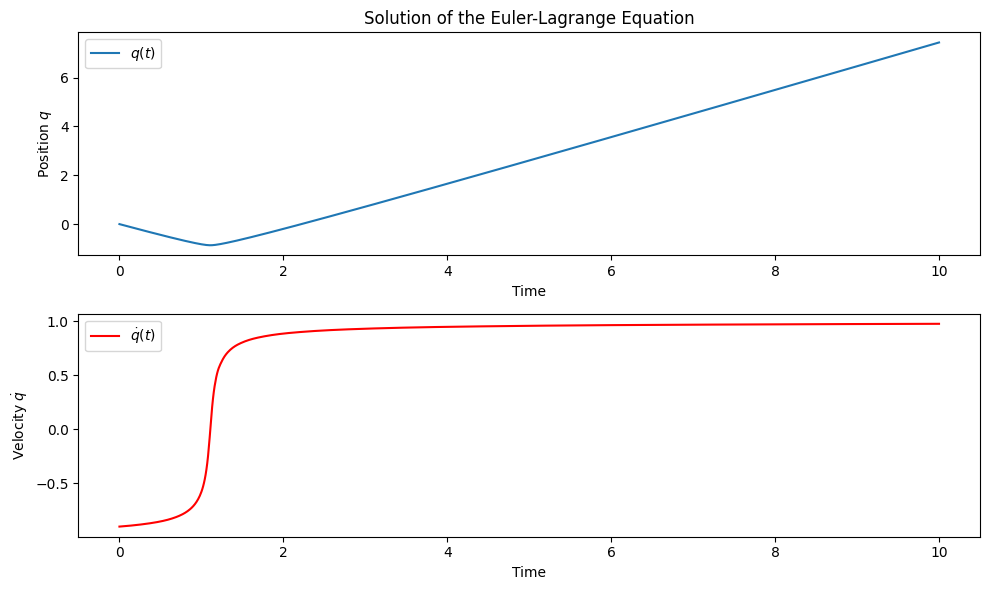

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# 定义微分方程
def dqdt(t, y, g):
    q, qdot = y  # y = [q, qdot]
    qddot = g * (1 - qdot**2)**(5/2) / (1 + 2 * qdot**2)
    return [qdot, qddot]

# 初始条件
q0 = 0.0      # q(0) = 0
qdot0 = -0.9   # qdot(0) = 0.4 (确保 |qdot| < 1)
g = 9.8       # 假设 g = 9.8（根据物理问题调整）

# 时间范围
t_span = (0, 10)  # 从 t=0 到 t=10
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # 时间点

# 求解
sol = solve_ivp(dqdt, t_span, [q0, qdot0], args=(g,), t_eval=t_eval, method='RK45')

# 提取结果
q = sol.y[0]      # q(t)
qdot = sol.y[1]   # qdot(t)

# 绘制结果
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(sol.t, q, label='$q(t)$')
plt.xlabel('Time')
plt.ylabel('Position $q$')
plt.title('Solution of the Euler-Lagrange Equation')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(sol.t, qdot, label='$\dot{q}(t)$', color='r')
plt.xlabel('Time')
plt.ylabel('Velocity $\dot{q}$')
plt.legend()
plt.tight_layout()
plt.show()


In [2]:
from jax.experimental.ode import odeint
import jax
import jax.numpy as jnp
import numpy as np # get rid of this eventually
import argparse
from jax import jit
from jax.experimental.ode import odeint
from functools import partial # reduces arguments to function by making some subset implicit

from jax.example_libraries import stax
from jax.example_libraries import optimizers

@jax.jit
def qdotdot(q, q_t, conditionals):
    g = conditionals
    
    q_tt = (
        g * (1 - q_t**2)**(5./2) / 
        (1 + 2 * q_t**2)
    )
    
    return q_t, q_tt

@jax.jit
def ofunc(y, t=None):
    q = y[::3]
    q_t = y[1::3]
    g = y[2::3]
    
    q_t, q_tt = qdotdot(q, q_t, g)
    return jnp.stack([q_t, q_tt, jnp.zeros_like(g)]).T.ravel()


@partial(jax.jit, static_argnums=(1, 2), backend='cpu')
#def gen_data(seed, batch, num):
def gen_data(seed, batch, num,fixed_g = 9.8):
    rng = jax.random.PRNGKey(seed)
    q0 = jax.random.uniform(rng, (batch,), minval=-10, maxval=10)
    qt0 = jax.random.uniform(rng+1, (batch,), minval=-0.99, maxval=0.99)
    #g = jax.random.normal(rng+2, (batch,))*10
    g = jnp.ones((batch,))*fixed_g

    y0 = jnp.stack([q0, qt0, g]).T.ravel()
    y1 = jnp.stack([q0, qt0, g]).T
    print(y1.shape)

    yt = odeint(ofunc, y0, jnp.linspace(0, 1, num=num),  atol=1e-6, rtol=1e-6)

    
    qall = yt[:, ::3]
    qtall = yt[:, 1::3]
    gall = yt[:, 2::3]
    
    return jnp.stack([qall, qtall]).reshape(2, -1).T, gall.reshape(1, -1).T, qdotdot(qall, qtall, gall)[1].reshape(1, -1).T

'''@partial(jax.jit, static_argnums=(1,))
def gen_data_batch(seed, batch):
    rng = jax.random.PRNGKey(seed)
    q0 = jax.random.uniform(rng, (batch,), minval=-10, maxval=10)
    qt0 = (jnp.tanh(jax.random.normal(jax.random.PRNGKey(1), (batch,))*2)*0.99999)#jax.random.uniform(rng+1, (batch,), minval=-1, maxval=1)
    g = jax.random.normal(rng+2, (batch,))*10
    
    return jnp.stack([q0, qt0]).reshape(2, -1).T, g.reshape(1, -1).T, qdotdot(q0, qt0, g)[1].reshape(1, -1).T
'''

dd = gen_data(0, 1, 1000)


print(dd[0][0,2])
print('qt', dd[0][:5, 1], 'g', dd[1][:5, 0], 'qtt', dd[2][:5, 0])
print('qt', dd[0][:5, 0], 'g', dd[1][:5, 0], 'qtt', dd[2][:5, 0])


(1, 3)
0.41314822
qt [0.41314822 0.4176898  0.42215496 0.42654538 0.4308627 ] g [9.8 9.8 9.8 9.8 9.8] qtt [4.5757637 4.4985847 4.423078  4.3492155 4.276966 ]
qt [8.953341  8.953756  8.954177  8.954601  8.9550295] g [9.8 9.8 9.8 9.8 9.8] qtt [4.5757637 4.4985847 4.423078  4.3492155 4.276966 ]


In [3]:
dd = gen_data(0, 128, 1000)

(128, 3)


In [4]:
print('qt', dd[0][:5, 1], 'g', dd[1][:5, 0], 'qtt', dd[2][:5, 0])
print('qt', dd[0][:5, 0], 'g', dd[1][:5, 0], 'qtt', dd[2][:5, 0])
print(dd[1][0, 0],dd[1][128, 0])
print(dd[1][1, 0],dd[1][129, 0])
print(dd[0][1, 0],dd[0][129, 0])


qt [ 0.41314822  0.6002258   0.11193506  0.05001947 -0.9819116 ] g [9.8 9.8 9.8 9.8 9.8] qtt [4.5757637e+00 1.8644511e+00 9.2637682e+00 9.6903276e+00 8.1437064e-04]
qt [ 8.953341   9.571598  -3.3541703 -0.6266308  1.3977742] g [9.8 9.8 9.8 9.8 9.8] qtt [4.5757637e+00 1.8644511e+00 9.2637682e+00 9.6903276e+00 8.1437064e-04]
9.8 9.8
9.8 9.8
9.571598 9.5722


In [2]:
from jax.experimental.ode import odeint
import jax
import jax.numpy as jnp
import numpy as np
import argparse
from functools import partial

def qdotdot(q, q_t, conditionals):
    g = conditionals
    
    q_tt = (
        g * (1 - q_t**2)**(5./2) / 
        (1 + 2 * q_t**2)
    )
    
    return q_t, q_tt

def ofunc(y, t=None):
    q = y[::3]
    q_t = y[1::3]
    g = y[2::3]
    
    q_t, q_tt = qdotdot(q, q_t, g)
    return jnp.stack([q_t, q_tt, jnp.zeros_like(g)]).T.ravel()

def gen_data(seed, batch, num):
    rng = jax.random.PRNGKey(seed)
    q0 = jax.random.uniform(rng, (batch,), minval=-10, maxval=10)
    qt0 = jax.random.uniform(rng+1, (batch,), minval=-0.99, maxval=0.99)
    g = jax.random.normal(rng+2, (batch,))*10

    y0 = jnp.stack([q0, qt0, g]).T.ravel()
    y1 = jnp.stack([q0, qt0, g]).T
    print(y1.shape)

    yt = odeint(ofunc, y0, jnp.linspace(0, 1, num=num), atol=1e-6, rtol=1e-6)
    
    qall = yt[:, ::3]
    qtall = yt[:, 1::3]
    gall = yt[:, 2::3]
    
    return jnp.stack([qall, qtall]).reshape(2, -1).T, gall.reshape(1, -1).T, qdotdot(qall, qtall, gall)[1].reshape(1, -1).T

dd = gen_data(0, 128, 1000)
f = dd[1]

print(f.shape)
print(dd[0][0,2])
print('qt', dd[0][:5, 1], 'g', dd[1][:5, 0], 'qtt', dd[2][:5, 0])
print('qt', dd[0][:5, 0], 'g', dd[1][:5, 0], 'qtt', dd[2][:5, 0])


(128, 3)
(128000, 1)
0.41314822
qt [ 0.41314822  0.6002258   0.11193506  0.05001947 -0.9819116 ] g [  4.612761    2.1626668 -12.121061   -6.3339176  17.351053 ] qtt [ 2.1537657e+00  4.1144755e-01 -1.1457828e+01 -6.2630343e+00
  1.4418560e-03]
qt [ 8.953341   9.571598  -3.3541703 -0.6266308  1.3977742] g [  4.612761    2.1626668 -12.121061   -6.3339176  17.351053 ] qtt [ 2.1537657e+00  4.1144755e-01 -1.1457828e+01 -6.2630343e+00
  1.4418560e-03]


In [29]:
import numpy as np
from scipy.integrate import odeint
import argparse
from functools import partial

def qdotdot(q, q_t, conditionals):
    g = conditionals
    
    q_tt = (
        g * (1 - q_t**2)**(5./2) / 
        (1 + 2 * q_t**2)
    )
    
    return q_t, q_tt

def ofunc(y, t):
    q = y[::3]
    q_t = y[1::3]
    g = y[2::3]
    
    q_t, q_tt = qdotdot(q, q_t, g)
    return np.stack([q_t, q_tt, np.zeros_like(g)]).T.ravel()

def gen_data(seed, batch, num, fixed_g=9.8):
    np.random.seed(seed)
    q0 = np.random.uniform(low=-10, high=10, size=(batch,))
    qt0 = np.random.uniform(low=-0.99, high=-0.8, size=(batch,))
    # 使用固定的g值而不是随机生成
    g = np.ones((batch,)) * fixed_g

    y0 = np.stack([q0, qt0, g]).T.ravel()
    y1 = np.stack([q0, qt0, g]).T
    print(y1.shape)

    t = np.linspace(0, 1, num=num)
    yt = odeint(ofunc, y0, t, atol=1e-6, rtol=1e-6)
    
    qall = yt[:, ::3]
    qtall = yt[:, 1::3]
    gall = yt[:, 2::3]
    
    return np.stack([qall, qtall]).reshape(2, -1).T, gall.reshape(1, -1).T, qdotdot(qall, qtall, gall)[1].reshape(1, -1).T

dd = gen_data(0, 5, 1000)



print("数据已保存为ode_results.csv")
print(dd[0][0,0])
print('qt', dd[0][:5, 1], 'g', dd[1][:5, 0], 'qtt', dd[2][:5, 0])
print('qt', dd[0][:5, 0], 'g', dd[1][:5, 0], 'qtt', dd[2][:5, 0])


(5, 3)
数据已保存为ode_results.csv
0.9762700785464951
qt [-0.86728012 -0.90685843 -0.82056313 -0.80690408 -0.91714611] g [9.8 9.8 9.8 9.8 9.8] qtt [0.11964506 0.04925959 0.25472511 0.30609465 0.0367398 ]
qt [ 0.97627008  4.30378733  2.05526752  0.89766366 -1.52690401] g [9.8 9.8 9.8 9.8 9.8] qtt [0.11964506 0.04925959 0.25472511 0.30609465 0.0367398 ]


In [32]:
import pandas as pd

# 解构dd中的数据
xy, g, qtt = dd

def larg(q, qt, g):
    T = (1-qt**2)**(-0.5) - 1 
    V =-g*q
    return T-V

L  = larg(xy[:, 0], xy[:, 1], g[:, 0])
print(L[:5])


# 创建DataFrame
df = pd.DataFrame({
    'q': xy[:, 0],   # 位置q
    'qt': xy[:, 1],  # 速度qt
    'g': g[:, 0],    # 条件g
    'qtt': qtt[:, 0], # 加速度qtt
    'L': L,            # 拉格朗日量L
})

# 保存为CSV文件
df.to_csv('relative_particle.csv', index=False)


[ 10.57620316  43.54995877  20.89123184   9.49006075 -13.45457103]


# 检查代码是否正确

In [27]:
import jax
import jax.numpy as jnp
import pandas as pd
from jax.experimental.ode import odeint
from jax import config
config.update("jax_enable_x64", True)



def qdotdot(q, q_t, conditionals):
    g = conditionals
    
    q_tt = (
        g * (1 - q_t**2)**(5./2) / 
        (1 + 2 * q_t**2)
    )
    
    return q_t, q_tt


# 读取 CSV 文件并转换为 NumPy 数组
data0 = pd.read_csv('./relative_particle.csv')#
tae = data0.to_numpy()

# 使用 JAX 的数组操作替换 PyTorch 的操作
state = jnp.array(tae[:, :2], dtype=jnp.float64)  # 转换为 JAX 数组
g = jnp.array(tae[:, 2], dtype=jnp.float64)  # 转换为 JAX 数组
true_q_ddot = jnp.array(tae[:, 3:], dtype=jnp.float64)  # 转换为 JAX 数组
# 将数据存储在字典中
data = {
    'inputs': state,
    'outputs': true_q_ddot,  # 真实的加速度
}


inputs, outputs = data['inputs'], data['outputs']
n_dim = inputs.shape[1] // 2
q = inputs[:, :n_dim]
q_t = inputs[:, n_dim:]
true_accelerations = outputs
print(q[:5],q_t[:5],true_accelerations[:5])
print(g)


dd = qdotdot(q, q_t, g)[1]
loss = jnp.mean((dd - true_accelerations)**2)  # 计算损失
print('Loss:', loss)



[[ 0.97627008]
 [ 4.30378733]
 [ 2.05526752]
 [ 0.89766366]
 [-1.52690401]] [[-0.86728012]
 [-0.90685843]
 [-0.82056313]
 [-0.80690408]
 [-0.91714611]] [[0.11964506]
 [0.04925959]
 [0.25472511]
 [0.30609465]
 [0.0367398 ]]
[9.8 9.8 9.8 ... 9.8 9.8 9.8]
Loss: 1.0887374420258375e-31


In [28]:
import numpy as np
from pysr import PySRRegressor

# 生成数据
X = np.random.randn(100, 2)
y = 2 * np.cos(X[:, 0]) + X[:, 1] ** 2

# 创建并训练模型
model = PySRRegressor(
    niterations=40,
    binary_operators=["+", "-", "/","^"],
    constraints={
        "^": (-1, 1)  # 限制为 x^(常数) 形式
    },
    unary_operators=["cos"],
    batching=True,
    model_selection="best",
    maxsize=15,
    verbosity=1
)

model.fit(X, y)

# 直接输出最佳函数表达式
print("\n最佳函数表达式:")
print(model.get_best().equation)

# 输出符号形式
print("\nSymPy 形式:")
print(model.sympy())


c:\anacoda\envs\pysr\Lib\site-packages\pysr\sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.222e+00  1.594e+01  y = 2.1533
4           1.297e+00  1.796e-01  y = 2.8171 - cos(x₁)
5           1.203e+00  7.523e-02  y = (1.3865 ^ x₁) ^ x₁
6           5.331e-01  8.136e-01  y = (2.1388 - cos(x₁)) ^ 1.8003
8           3.545e-01  2.040e-01  y = cos(x₀) + ((1.3865 ^ x₁) ^ x₁)
9           3.178e-01  1.094e-01  y = ((1.3432 ^ x₁) ^ x₁) / cos(cos(x₀))
10          1.345e-01  8.595e-01  y = ((x₁ / (x₁ ^ -1)) + cos(x₀)) + 0.65546
11          2.048e-14  1.594e+01  y = (cos(x₀) + cos(x₀)) + (x₁ / (x₁ ^ -1))
───────────────────────────────────────────────────────────────────────────────────────────────────

最佳函数表达式:
(cos(x0) + cos(x0)) + (x1 / (x1 ^ -1.0))

SymPy 形式:
cos(x0) + cos(x0) + x1/(x1**(-1.0))
  - outputs\20250504_183647_GyaIUy\hall_of_fame.csv
